In [1]:
import os
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn.functional as F

import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch import optim
import torchvision.transforms as transforms

import clip

/Data/recipe/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
CONTEXT_LENGTH = 77
SAMPLE_SIZE = None
RUN_NAME = "ingredients_data"
TRAIN_PROP = 0.7
VAL_PROP = 0.2
BATCH_SIZE = 100
NUM_WORKERS = 0
EPOCHS = 30
LEARNING_RATE = 5e-6

# Params same as paper
BETAS = (0.9,0.98)
EPS = 1e-6
WEIGHT_DECAY = 0.2

In [3]:
models = clip.available_models()
print(models)
model, preprocess = clip.load('RN50', device, jit=False)

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [4]:
print(model)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

## Create Dataset

In [5]:
class TextImg_Dataset(Dataset):
    def __init__(self, data_dir, images_dir, images, ingredients, instructions, augmented_text=False, augmented_image=False):
        self.data_dir = data_dir
        self.images_dir = images_dir
        self.images_paths = images
        self.ingredients = ingredients
        self.instructions = instructions
        assert (len(ingredients)==len(images)==len(instructions))
        self.augmented_text = augmented_text
        self.augmented_image = augmented_image

    def __len__(self):
        return len(self.images_paths)
    
    def transform_img(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
            transforms.RandomRotation(30),  # Randomly rotate the image by up to 30 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
        ])
        return transform(img)
    
    def __getitem__(self, index):
        img_path = self.images_paths[index]
        txt = self.ingredients[index]
        if (type(txt)!=str):
            txt = self.instructions[index]
        else:
            txt += self.instructions[index]
        text_tokens = clip.tokenize(txt, context_length=CONTEXT_LENGTH, truncate=True).squeeze().to(device) # torch.Size([77])
        # print(type(text_tokens), text_tokens.shape)
        path = os.path.join(self.data_dir, self.images_dir, img_path)
        img = Image.open(path)
        if self.augmented_image:
            img = self.transform_img(img)
        image = preprocess(img).to(device) # torch.Size([3, 224, 224])
        # print(type(image), image.shape)
        return text_tokens, image


In [6]:
summary_bert_path = "data/Summaries/Summary_Bert_77.csv"
data_dir = "data"
images_dir = "Food Images/Food Images"

In [7]:
summary_df = pd.read_csv(summary_bert_path)
liste_images = summary_df["Image_Name"].tolist()
liste_ingredients = summary_df["Ingredients"].tolist()
liste_instructions = summary_df["Summary_Bert_77"].tolist()
if SAMPLE_SIZE != None:
    liste_images=liste_images[:SAMPLE_SIZE]
    liste_ingredients=liste_ingredients[:SAMPLE_SIZE]
    liste_instructions=liste_instructions[:SAMPLE_SIZE]
liste_images = [image + ".jpg" for image in liste_images]

In [8]:
liste_images[0], liste_ingredients[0]

('miso-butter-roast-chicken-acorn-squash-panzanella.jpg',
 'whole chicken kosher salt divided plus moresmall acorn squash about total finely chopped sage finely chopped rosemary unsalted butter melted plus room temperature ground allspice Pinch of crushed red pepper flakes Freshly ground black pepperloaf goodquality sturdy white bread torn intopieces aboutcupsmedium apples such as Gala or Pink Lady aboutoz total cored cut intopieces extravirgin olive oilsmall red onion thinly sliced apple cider vinegar white miso  cup allpurpose flour unsalted butter room temperature  cup dry white winecups unsalted chicken broth white miso Kosher salt freshly ground pepper')

In [9]:
assert(len(liste_ingredients) == len(liste_images))
length = len(liste_images)
print(length)
train_size = int(length*TRAIN_PROP)
val_size = int(length*VAL_PROP)

12710


In [10]:
train_dataset = TextImg_Dataset(data_dir, images_dir, liste_images[:train_size], liste_ingredients[:train_size], liste_instructions[:train_size])
train_dataset_augmented = TextImg_Dataset(data_dir, images_dir, liste_images[:train_size], liste_ingredients[:train_size], liste_instructions[:train_size], augmented_text=True, augmented_image=True)
val_dataset = TextImg_Dataset(data_dir, images_dir, liste_images[train_size:train_size+val_size], liste_ingredients[train_size:train_size+val_size], liste_instructions[:val_size])
test_dataset = TextImg_Dataset(data_dir, images_dir, liste_images[train_size+val_size:], liste_ingredients[train_size+val_size:], liste_instructions[train_size+val_size:])

In [11]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_dataset, batch_size=500, shuffle=False, num_workers=NUM_WORKERS)

In [12]:
len(train_dl), next(iter(train_dl))

(89,
 [tensor([[49406,   326,  5427,  ...,   518,  6952, 49407],
          [49406,  1937,   661,  ...,   661, 13707, 49407],
          [49406, 10752, 37742,  ...,     0,     0,     0],
          ...,
          [49406,  1937,  2052,  ...,  8986,  7232, 49407],
          [49406, 35498,  1345,  ...,   269, 21684, 49407],
          [49406, 10016,   569,  ...,   750,  1942, 49407]], device='cuda:0',
         dtype=torch.int32),
  tensor([[[[ 0.4121, -0.0259, -0.3032,  ..., -0.7266, -0.8288, -0.7558],
            [ 0.1347,  0.2953,  0.2369,  ..., -0.8288, -0.9748, -0.7850],
            [ 0.2953,  0.7333,  0.8501,  ..., -1.0185, -1.0769, -0.8726],
            ...,
            [ 0.9376,  0.2807, -0.3470,  ...,  0.9668,  1.2734,  1.5654],
            [ 0.6457,  0.0179, -0.4638,  ...,  0.8938,  1.3464,  1.5800],
            [ 0.0617, -0.4930, -0.6244,  ...,  0.8647,  1.1858,  1.3902]],
  
           [[-0.3114, -0.7166, -0.9417,  ..., -1.1518, -1.2268, -1.1218],
            [-0.6265, -0.4014, -0.

## Fine Tune CLIP

In [13]:
def compute_loss(text_embeddings, image_embeddings):
    logits = (text_embeddings @ image_embeddings.T)
    images_similarity = image_embeddings @ image_embeddings.T
    texts_similarity = text_embeddings @ text_embeddings.T
    targets = F.softmax(
        (images_similarity + texts_similarity) / 2, dim=-1
    )
    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
    return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = torch.nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()
    
def get_accuracy(text_features, image_features):
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    ground_truth = torch.arange(similarity.shape[0]).to(device)
    max_indices = torch.argmax(similarity, dim=1)
    return torch.mean((max_indices == ground_truth).float()).item() *100

def convert_models_to_fp32(model): 
    for p in model.parameters():
        p.data = p.data.float()
        print(type(p.data), p.data)
        p.grad.data = p.grad.data.float() 

In [14]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,betas=BETAS,eps=EPS,weight_decay=WEIGHT_DECAY)
train_losses = []
val_losses = []
val_accuracies = []

In [15]:
clip.model.convert_weights(model)

for ep in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_dl, desc=f'Epoch {ep+1}/{EPOCHS} [Training]'): 
        optimizer.zero_grad()
        text, img = batch
        # print(text.shape, img.shape)
        text_features = model.encode_text(text)
        image_features = model.encode_image(img)
        loss = compute_loss(text_features, image_features)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss)

    # VALIDATION LOOP
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_acc = 0
        for b_idx, batch in enumerate(tqdm(val_dl, desc=f'Epoch {ep+1}/{EPOCHS} [Validation]')): 
            text, img = batch
            text_features = model.encode_text(text)
            image_features = model.encode_image(img)
            loss = compute_loss(text_features, image_features)
            val_loss+=loss.item()
            val_acc += get_accuracy(text_features, image_features)
        val_accuracies.append(val_acc/b_idx+1)
        val_losses.append(val_loss)
    torch.save(model.state_dict(), "data/checkpoints/%s_ep%d.pt" %(RUN_NAME, ep))    

Epoch 30/30 [Validation]: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]


In [22]:
train_losses, val_losses, val_accuracies

([346.033203125,
  289.7734375,
  247.79296875,
  211.939453125,
  178.1201171875,
  144.736328125,
  111.90380859375,
  86.1103515625,
  64.435546875,
  49.29736328125,
  37.89111328125,
  28.4189453125,
  22.7314453125,
  18.835205078125,
  17.749755859375,
  13.55023193359375,
  13.0933837890625,
  12.20526123046875,
  11.22705078125,
  10.70062255859375,
  10.45391845703125,
  9.62762451171875,
  8.86785888671875,
  8.327789306640625,
  8.59307861328125,
  8.642791748046875,
  8.12890625,
  7.94256591796875,
  7.880950927734375,
  7.304595947265625],
 [104.806640625,
  100.169921875,
  98.34765625,
  98.630859375,
  99.787109375,
  106.716796875,
  107.708984375,
  111.943359375,
  113.935546875,
  116.529296875,
  120.6015625,
  122.5234375,
  127.236328125,
  128.494140625,
  131.158203125,
  132.181640625,
  133.58984375,
  134.1484375,
  135.6484375,
  135.673828125,
  137.01171875,
  137.8515625,
  139.59765625,
  138.193359375,
  142.93359375,
  141.0234375,
  144.2890625,
  

In [23]:
import matplotlib.pyplot as plt

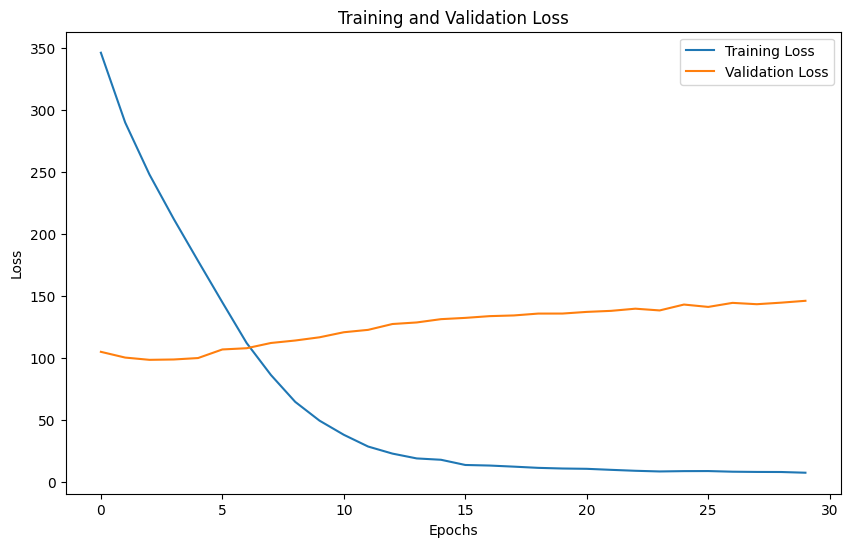

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('data/plots/%s_losses.png'%RUN_NAME)
plt.show()

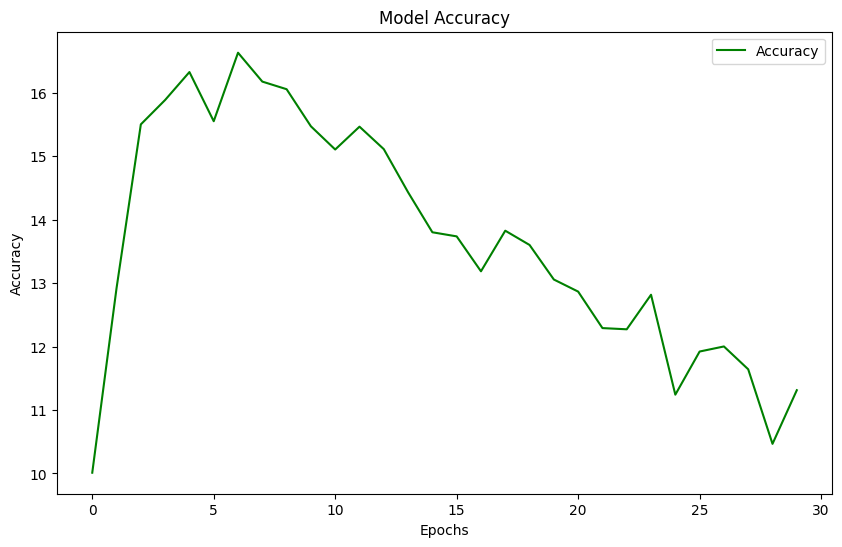

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.savefig('data/plots/%s_accuracies.png'%RUN_NAME)
plt.show()

## Run Inference on test_set

In [26]:
len(test_dl), train_size+val_size, length

(3, 11439, 12710)

In [27]:
with torch.no_grad():
    for b in test_dl:
        text, img = b
        print(text.shape, img.shape)
        text_features = model.encode_text(text)
        image_features = model.encode_image(img)

        accuracy = get_accuracy(text_features, image_features)

        # clip_score = torch.matmul(image_features, text_features.T)
        print(f'Accuracy: {accuracy:.2f} %')

torch.Size([500, 77]) torch.Size([500, 3, 224, 224])
Accuracy: 5.60 %
torch.Size([500, 77]) torch.Size([500, 3, 224, 224])
Accuracy: 3.60 %
torch.Size([271, 77]) torch.Size([271, 3, 224, 224])
Accuracy: 7.01 %


In [52]:
test_ingredients = liste_ingredients[-200:]

In [53]:
text_tokens = clip.tokenize(test_ingredients, context_length=CONTEXT_LENGTH, truncate=True).squeeze().to(device) # torch.Size([77])
# print(type(text_tokens), text_tokens.shape)

In [54]:
good, bad = 0, 0

for title in liste_images[-200:]:
    path = os.path.join(data_dir, images_dir, title)
    img = Image.open(path)
    test_img = preprocess(img).unsqueeze(0).to(device) 

    with torch.no_grad():
        image_features = model.encode_image(test_img)
        text_features = model.encode_text(text_tokens)
        
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        values, indices = torch.topk(similarity[0], k=5)

        # Convert the tensors to numpy arrays
        values = values.cpu().numpy()
        indices = indices.cpu().numpy()

        # Create a list of tuples containing the values and indices
        values_indices = list(zip(values, indices))

        # Sort the list in descending order based on the values
        values_indices.sort(reverse=True)

        # Extract the sorted values and indices
        sorted_values, sorted_indices = zip(*values_indices)

        max_index=sorted_indices[0] #text qui correspond à l'image selon le modèle 
        
        label=liste_images[max_index] #rectte

        if title == label:
            good += 1

        else:
            bad += 1


print(good, bad)

0 200
